# Data Cleaning

**Note**: To run notebooks on the cluster, you will need the Jupyter extension in VSCode and also the *ipykernel* library from the *requirements.txt* in Lecture_1.

## Missing Values

There are three main options how to deal with missing values:

1. drop rows with missing values
 - probably ok, if you have enough data
 - but can introduce [biases in your downstream models](https://ssc.io/publication/fairprep-promoting-data-to-a-first-class-citizen-in-studies-on-fairness-enhancing-interventions-edbt/)
2. replace missing values with placeholders
 - probably ok, if you have a nonlinear downstream model and the right type of missingness
 - you can come up with the placeholder either from the statistics of your data e.g. mean or median value, or through informed decision rules (usually domain knowledge required)
3. impute missing values 
 - with some standard ML model e.g. in [``sklearn``](https://scikit-learn.org/stable/index.html)
 - via more modern approaches (stay tuned for our invited speaker at 1pm)

In [1]:
import pandas as pd
import numpy as np

berlin_population_dict = {
 '1945': 2807405,
 '1950': 3336026,
 '1955': None,                         
 '1960': 3274016,
 '1965': np.nan, # pandas understands different missing values                        
 '1970': 3208719}

population_w_nans = pd.Series(berlin_population_dict)
population_w_nans

1945    2807405.0
1950    3336026.0
1955          NaN
1960    3274016.0
1965          NaN
1970    3208719.0
dtype: float64

### 1. Dropping Rows

Easy with boolean indexing in pandas or numpy

In [2]:
population_w_nans.isnull()

1945    False
1950    False
1955     True
1960    False
1965     True
1970    False
dtype: bool

In [6]:
population_w_nans[~population_w_nans.isnull()]

1945    2807405.0
1950    3336026.0
1960    3274016.0
1970    3208719.0
dtype: float64

In [7]:
population_w_nans.dropna()

1945    2807405.0
1950    3336026.0
1960    3274016.0
1970    3208719.0
dtype: float64

### 2. Filling with Placeholder


In [9]:
population_w_nans.fillna(method='ffill') # just copy-paste the last valid value

/tmp/ipykernel_1117/2403931827.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_w_nans.fillna(method='ffill') # just copy-paste the last valid value


1945    2807405.0
1950    3336026.0
1955    3336026.0
1960    3274016.0
1965    3274016.0
1970    3208719.0
dtype: float64

In [8]:
population_w_nans.fillna(method='bfill') # just copy-paste the next valid value

/tmp/ipykernel_1117/1579020210.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_w_nans.fillna(method='bfill') # just copy-paste the next valid value


1945    2807405.0
1950    3336026.0
1955    3274016.0
1960    3274016.0
1965    3208719.0
1970    3208719.0
dtype: float64

In [ ]:
population_w_nans.fillna(value=population_w_nans.median()) # replace with median

1945    2807405.0
1950    3336026.0
1955    3241367.5
1960    3274016.0
1965    3241367.5
1970    3208719.0
dtype: float64

#### Filling with Placeholder in ``sklearn``

This way you'll be able to replace missing values in ML Pipelines

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent") # replace with mode
imp.fit_transform(population_w_nans.to_numpy().reshape(-1,1))

array([[2807405.],
       [3336026.],
       [2807405.],
       [3274016.],
       [2807405.],
       [3208719.]])

### 3. Imputation

#### Numeric Imputation

In [7]:
# Generate a dataset of random points between -pi and pi along with their squares (+ some noise)
num_samples = 100
numeric_data = np.random.uniform(-np.pi, np.pi, (num_samples,))
df = pd.DataFrame({
    "x": numeric_data,
    "f(x)": numeric_data ** 2 + np.random.normal(0, .01, (num_samples,)),
})
# Mask 20% of the values
mask = np.random.rand(df.shape[0]) < 0.2
df.loc[mask,'f(x)'] = np.nan
df

,x,f(x)
0,-2.546607,NaN
1,-0.654449,NaN
2,-2.861570,8.202733
3,-2.923891,8.556653
4,-2.359287,5.577280
...,...,...
95,1.672977,NaN
96,-3.079112,9.474895
97,1.745492,3.032480
98,1.273802,1.607955


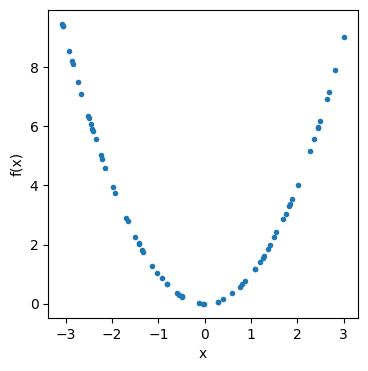

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=[4,4])
plt.plot(df['x'],df['f(x)'],'.')
plt.ylabel("f(x)")
plt.xlabel("x");

##### ``sklearn`` - RidgeRegression

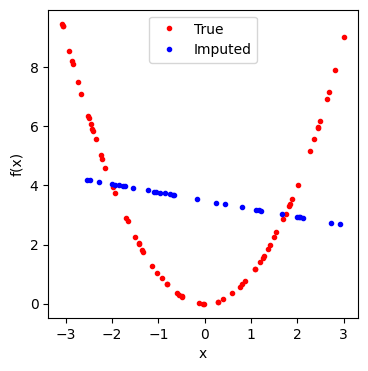

In [9]:
from sklearn.experimental import enable_iterative_imputer # you need to import this to run the sklearn imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
X_train = df.loc[mask==0,:].values
imp.fit(X_train)

X_test = df.loc[mask>0,:].values
X_test_imputed = imp.transform(X_test)

plt.figure(figsize=[4,4])
plt.plot(X_train[:,0], X_train[:,1], 'r.',
         X_test_imputed[:,0], X_test_imputed[:,1], 'b.')
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend(['True', 'Imputed']);

**Question**: Why does the model predict a line here?
Recall what Ridge Regression and Least Squares are (and also check the sklearn documentation for `IterativeImputer`).

Try to modify the code above so that sklearn solves the Least-Squares to fit a parabola, not a straight line.

##### ``sklearn`` - RandomForest

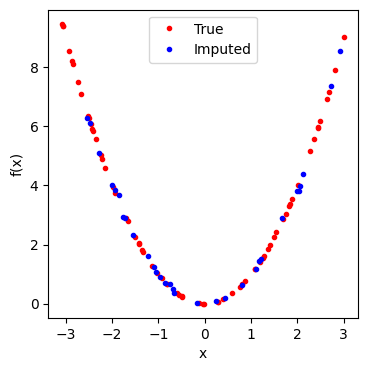

In [11]:
from sklearn.ensemble import RandomForestRegressor
imp = IterativeImputer(estimator=RandomForestRegressor(),
                       max_iter=10, random_state=0)
X_train = df.loc[mask==0,:].values
imp.fit(X_train)

X_test = df.loc[mask>0,:].values
X_test_imputed = imp.transform(X_test)

plt.figure(figsize=[4,4])
plt.plot(X_train[:,0], X_train[:,1], 'r.',
         X_test_imputed[:,0], X_test_imputed[:,1],'b.')
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend(['True', 'Imputed']);

##### ``sklearn`` - KNN

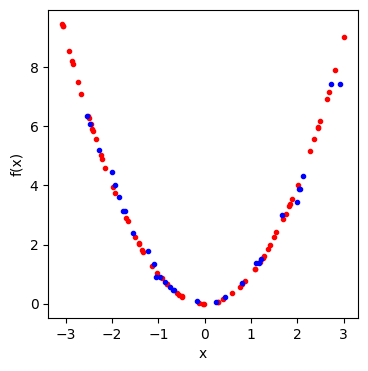

In [12]:
from sklearn.impute import KNNImputer
imp = KNNImputer()

X_train = df.loc[mask==0,:].values
imp.fit(X_train)

X_test = df.loc[mask>0,:].values
X_test_imputed = imp.transform(X_test)

plt.figure(figsize=[4,4])
plt.plot(X_train[:,0], X_train[:,1], 'r.',
         X_test_imputed[:,0], X_test_imputed[:,1],'b.')
plt.ylabel("f(x)")
plt.xlabel("x");

#### Categorical Imputation

In [19]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Example data with missing categorical values
data = pd.DataFrame({
    'Color': ['Red', 'Blue', np.nan, 'Green', 'Blue', np.nan]
})

# Replace the categorical strings with their class indexes, keeping NaNs as they are
data['Color_class'] = data['Color'].astype('category').cat.codes.replace(-1, np.nan)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Fit and transform the data
data['Color_imputed'] = imputer.fit_transform(data[['Color_class']])

print(data)

   Color  Color_class  Color_imputed
0    Red          2.0            2.0
1   Blue          0.0            0.0
2    NaN          NaN            0.0
3  Green          1.0            1.0
4   Blue          0.0            0.0
5    NaN          NaN            0.0


Sometimes, missing values can and should be imputed in accordance with fixed rules defined beforehand by domain experts. Otherwise, we run the risk of introducing non-realistic/OOD data points to our cleaned dataset.

See an example [here](https://github.com/calgo-lab/BGR/blob/00406bb2bfa4839fa00087474636e1b5b6781e39/bgr/soil/data/horizon_tabular_data.py#L245) for imputing categoricals in sequentially structured soil data.

## String Deduplication / Normalization

- Often cleaning involves removal of duplicates or typos
- Some typos can be easily removed by replacing them with similar but more frequent strings

In [27]:
s = pd.read_csv("misspelled_words_simulated.txt", names=['word'])['word']
s[s.str.startswith('ye')].unique()

array(['year', 'yera', 'years', 'yeasr', 'yeras', 'yersa'], dtype=object)

How should we check if a word is misspelled?

In [28]:
word_counts = s.value_counts()
correct_words = word_counts[word_counts >= 10].index
misspelled_words = word_counts[word_counts < 10].index
misspelled_words[:50]

Index(['fiels', 'mear', 'councellors', 'boaut', 'buring', 'gae', 'councellor',
       'fiel', 'alot', 'sould', 'leanr', 'cervial', 'restraunt', 'alusion',
       'diea', 'relized', 'noone', 'beggin', 'unsed', 'neigbour',
       'phenomenonly', 'behavour', 'withdrawl', 'neice', 'coorperation',
       'idesa', 'anual', 'ethose', 'manouver', 'sheat', 'lible', 'empirial',
       'achived', 'surrended', 'fleed', 'achive', 'medeival', 'orginal',
       'wether', 'lief', 'iminent', 'imanent', 'lonly', 'archeaologist',
       'dieing', 'maked', 'imigrant', 'specif', 'haev', 'addres'],
      dtype='object', name='word')

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np

# Compute hashed character ngram counts
vect = HashingVectorizer(analyzer='char_wb', ngram_range=(1,5), n_features=2**20, binary=True)
correct_words_ngrams = vect.transform(correct_words)
misspelled_words_ngrams = vect.transform(misspelled_words)

# Compute string similarity between correct and misspelled words
similarity = correct_words_ngrams.dot(misspelled_words_ngrams.T)

In [36]:
# Find most similar correct word for each misspelled word
most_similar_correct_word = similarity.toarray().argsort(axis=0)[-1,:]
corrections = [(word,correct_words[most_similar_correct_word[idx]]) for idx, word in enumerate(misspelled_words)]
corrections[:20]

[('fiels', 'fields'),
 ('mear', 'year'),
 ('councellors', 'counsellors'),
 ('boaut', 'boat'),
 ('buring', 'burin'),
 ('gae', 'Gael'),
 ('councellor', 'counsellor'),
 ('fiel', 'field'),
 ('alot', 'allot'),
 ('sould', 'should'),
 ('leanr', 'lean'),
 ('cervial', 'cervical'),
 ('restraunt', 'restraint'),
 ('alusion', 'allusion'),
 ('diea', 'die'),
 ('relized', 'realized'),
 ('noone', 'one'),
 ('beggin', 'begging'),
 ('unsed', 'unused'),
 ('neigbour', 'neighbour')]

In [ ]:
# Replace misspelled values in pandas Series with corrected ones
to_replace, replacement = zip(*corrections)
s = s.replace(to_replace, replacement)

Other times, by 'cleaning' people mean 'simplifying' the problem their model is supposed to solve. 

Example: reducing the complexity of label spaces via e.g. clustering.

See one example for [clustering soil colors](https://github.com/calgo-lab/BGR/blob/00406bb2bfa4839fa00087474636e1b5b6781e39/bgr/soil/data/horizon_tabular_data.py#L511)

and one example for [clustering soil horizon classes](https://github.com/calgo-lab/BGR/blob/00406bb2bfa4839fa00087474636e1b5b6781e39/bgr/soil/data/horizon_tabular_data.py#L332) through string similarities computed with the Levenshtein distance.

## Anomaly Detection

* Anomaly detection is an important task, but very difficult.
* We usually don't know what is normal/anomalous.
* If we have examples of anomalies, they are usually *very rare*.
* For evaluation, we can use *classification metrics* but we need labels for that.

There are great libraries for anomaly detection:
* [scikit-learn anomaly detection demo](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)
* [pyOD](https://github.com/yzhao062/pyod#quick-start-for-outlier-detection)

### Simple Univariate Example

Consider univariate data $x\in R^1$ drawn from a normal distribution $\mathcal{N}(\mu,\sigma^2)$.

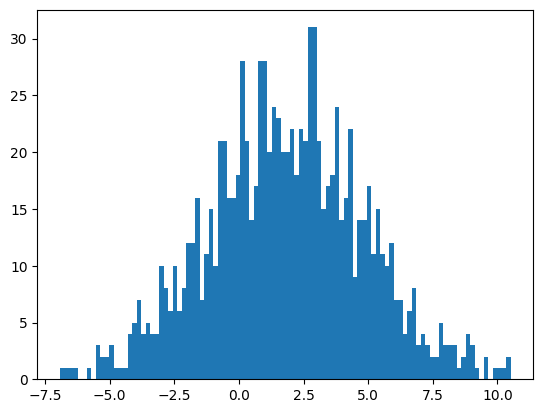

In [21]:
mu = 2
sigma = 3
x = np.random.randn(1000) * sigma + mu

plt.hist(x, bins=100);

**What's an anomalous data point?**

The likelihood of each sample under this distribution is given by 

$p(x) = {\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}$

So you can compute the likelihood of any given data point as:

In [22]:
def gauss_likelihood(x, mu, sigma):
    '''
    Computes the likelihood of x assuming x is from a 
    normal distribution with mean mu and standard deviation sigma
    '''
    denom = (np.sqrt(2.*np.pi)*sigma)
    num = np.exp(-.5*((x - mu) / sigma)**2)
    return num/denom

print(gauss_likelihood(2., mu,sigma))

# alternatively you can use the scipy.stats package
from scipy.stats import norm
my_gauss = norm(mu, sigma)
print(my_gauss.pdf(2))

0.1329807601338109
0.1329807601338109


**Defining Anomaly**

Given a data point and a (not necessarily generative) model of your data, you can define a threshold for *what's an anomaly*. 

For instance, a common threshold is to assume that data points for which $p(x)< 0.05$ or $p(x)< 0.01$ are anomalous.  

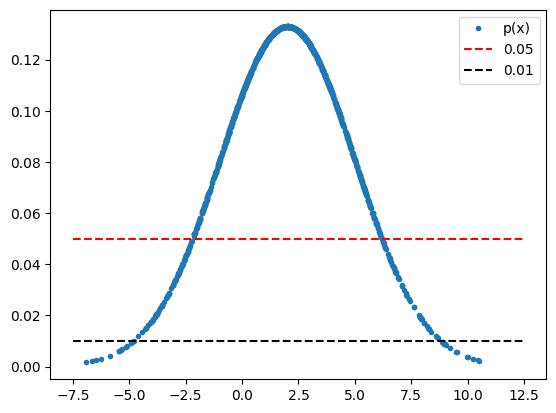

In [24]:
steps = np.arange(-10,100)
plt.plot(x, gauss_likelihood(x,mu,sigma),'.');
plt.plot([-7.5,12.5],[.05,.05],'r--')
plt.plot([-7.5,12.5],[.01,.01],'k--')
plt.legend(['p(x)','0.05','0.01']);

### Two more Sophisticated Examples

* Simple Parametric Approach: Assuming Gaussian Data
* Advanced Non-parametric: Isolation Forest

Example taken from an [sklearn tutorial](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

In [25]:
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['figure.figsize'] = [5, 5]

n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25]))]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plot_num = 1
rng = np.random.RandomState(42)

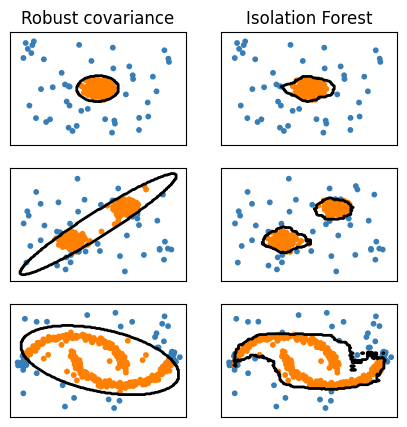

In [26]:
for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:

        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=12)

        y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
        
plt.show()